In [1]:
import sys
sys.path.append('../src')

import numpy as np
import joblib
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

import simulation

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{siunitx}\usepackage{sansmath}\sansmath')
params = {
    'legend.fontsize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
}
plt.rcParams.update(params)

In [3]:
cerro_toco_atm_profile = np.loadtxt('../input-data/cerro_toco_atm_profile.txt')

In [4]:
mag_vec = SkyCoord(-5.9, 21.2, frame='altaz', unit='deg')
obs_direction = SkyCoord(0, 90, frame='altaz', unit='deg')

In [5]:
def run_calc(i):
    simulator = simulation.AtmSim(22738, cerro_toco_atm_profile, 5200)
    return simulator.calc_propagation_matrix_avg(freqs[i], mag_vec.separation(obs_direction).rad, 0)

In [6]:
freqs = np.linspace(10, 200, 1901)
mats = joblib.Parallel(n_jobs=10)(joblib.delayed(run_calc)(i) for i in range(freqs.size))

In [7]:
vsp = np.array([simulation.to_V(i) for i in mats])
vsn = vsp.copy()

neg = vsp <= 0
for i in range(1, vsp.size):
    if vsp[i] <= 0 and neg[i - 1]:
        vsp[i] = np.nan
pos = vsn > 0
for i in range(1, vsn.size):
    if vsp[i] > 0 and pos[i - 1]:
        vsn[i] = np.nan
vsp = np.abs(vsp)
vsn = np.abs(vsn)
ps = np.sqrt([simulation.to_Q(i)**2 + simulation.to_U(i)**2 for i in mats])

In [8]:
np.savez_compressed('../result-data/frequency-dependence.npz', freqs=freqs, vsp=vsp, vsn=vsn, ps=ps)

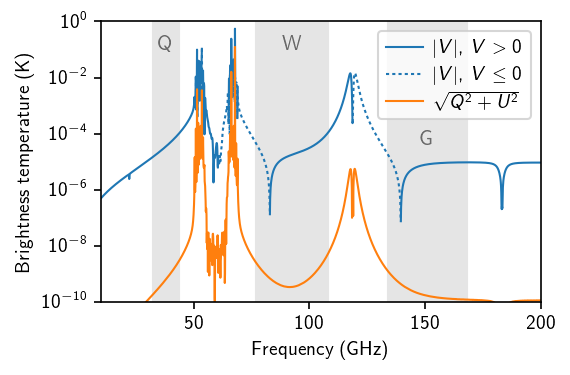

In [9]:
plt.figure(figsize=(3.9, 2.6), dpi=150)

plt.axvspan(32.3, 43.7, color='#e5e5e5')
plt.text(38.0, 0.1, 'Q', color='dimgray', transform=plt.gca().transData, ha='center')
plt.axvspan(77, 108, color='#e5e5e5')
plt.text(92.5, 0.1, 'W', color='dimgray', transform=plt.gca().transData, ha='center')
plt.axvspan(134, 168, color='#e5e5e5')
plt.text(151.0, 0.00004, 'G', color='dimgray', transform=plt.gca().transData, ha='center')
#plt.axvspan(203, 241, color='#dddddd')

plt.semilogy(freqs, vsp, c='tab:blue', label='$|V|$, $V > 0$', lw=1)
plt.semilogy(freqs, vsn, c='tab:blue', dashes=(1.5, 1.5), label='$|V|$, $V \leq 0$', lw=1)
plt.semilogy(freqs, ps, c='tab:orange', label='$\sqrt{Q^2 + U^2}$', lw=1)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Brightness temperature (K)')
plt.xlim((10, 200))
plt.ylim((1e-10, 1e0))
plt.legend(labelspacing=0.4, handletextpad=0.6)
plt.tight_layout()

plt.savefig('../result-data/frequency-dependence.pdf')